In [5]:
!pip install -q langgraph langchain_core langgraph-checkpoint-sqlite langchain_groq tavily-python

In [6]:
!sudo apt-get install python3-dev graphviz libgraphviz-dev pkg-config

'sudo' is not recognized as an internal or external command,
operable program or batch file.


In [7]:
!sudo pip install pygraphviz

'sudo' is not recognized as an internal or external command,
operable program or batch file.


In [57]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage

from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [58]:
class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int

In [ ]:
from langchain_groq import ChatGroq
import os
model = ChatGroq(temperature=0.0, model="llama-3.3-70b-versatile")

In [60]:
PLAN_PROMPT = """You are an expert writer tasked with writing a high level outline of an essay. \
Write such an outline for the user provided topic. Give an outline of the essay along with any relevant notes \
or instructions for the sections."""

In [61]:
WRITER_PROMPT = """You are an essay assistant tasked with writing excellent 5-paragraph essays.\
Generate the best essay possible for the user's request and the initial outline. \
If the user provides critique, respond with a revised version of your previous attempts. \
Utilize all the information below as needed:

------

{content}"""

In [62]:
REFLECTION_PROMPT = """You are a teacher grading an essay submission. \
Generate critique and recommendations for the user's submission. \
Provide detailed recommendations, including requests for length, depth, style, etc."""

In [63]:
RESEARCH_PLAN_PROMPT = """You are a researcher charged with providing information that can \
be used when writing the following essay. Generate a list of search queries that will gather \
any relevant information. Only generate 3 queries max."""


In [64]:
RESEARCH_CRITIQUE_PROMPT = """You are a researcher charged with providing information that can \
be used when making any requested revisions (as outlined below). \
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max."""


In [65]:
from pydantic import BaseModel

class Queries(BaseModel):
    queries: List[str]

In [ ]:
from tavily import TavilyClient
import os
tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

In [67]:
def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(messages)
    return {"plan": response.content}

In [117]:
def research_plan_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ])
    content = state.get("content") or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [118]:
def generation_node(state: AgentState):
    content = "\n\n".join(state['content'] or [])
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")
    messages = [
        SystemMessage(
            content=WRITER_PROMPT.format(content=content)
        ),
        user_message
        ]
    response = model.invoke(messages)
    return {
        "draft": response.content,
        "revision_number": state.get("revision_number", 1) + 1
    }


In [119]:
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT),
        HumanMessage(content=state['draft'])
    ]
    response = model.invoke(messages)
    return {"critique": response.content}

In [120]:
def research_critique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    content = state.get("content") or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [121]:
def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"

In [122]:
builder = StateGraph(AgentState)

In [123]:
builder.add_node("planner", plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("research_critique", research_critique_node)

In [124]:
builder.set_entry_point("planner")

In [125]:
builder.add_conditional_edges(
    "generate",
    should_continue,
    {END: END, "reflect": "reflect"}
)


In [126]:
builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")

builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")

In [127]:
graph = builder.compile(checkpointer=memory)

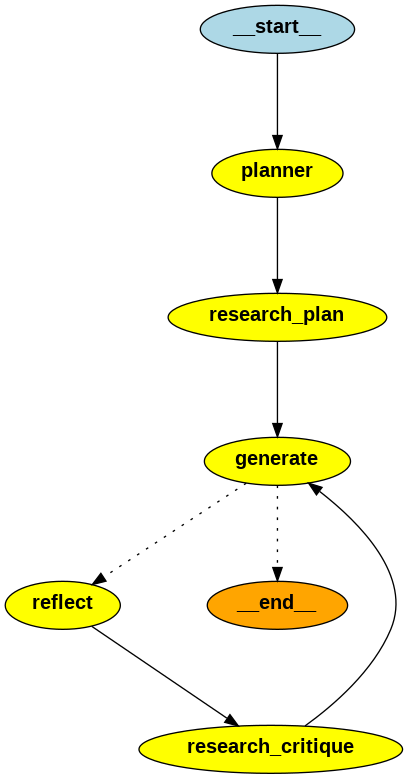

In [128]:
from IPython.display import Image

Image(graph.get_graph().draw_png())

In [129]:
thread = {"configurable": {"thread_id": "1"}}
for s in graph.stream({
    'task': "what is the difference between langchain and langsmith",
    "max_revisions": 2,
    "revision_number": 1,
}, thread):
    print(s)

{'planner': {'plan': "Here is a high-level outline for an essay on the difference between LangChain and LangSmith:\n\n**I. Introduction**\n* Briefly introduce the topic of AI-powered language models and their applications\n* Mention LangChain and LangSmith as two notable examples of language model frameworks\n* Thesis statement: While both LangChain and LangSmith are designed to work with large language models, they differ significantly in their architecture, functionality, and use cases.\n\n**II. Overview of LangChain**\n* Define LangChain and its primary purpose (e.g., a framework for building applications on top of large language models)\n* Discuss the key features of LangChain, such as its modular design, support for multiple models, and ease of integration with other tools and services\n* Provide examples of use cases where LangChain is particularly well-suited (e.g., chatbots, language translation, text summarization)\n\n**III. Overview of LangSmith**\n* Define LangSmith and its 

## Essay Writer Interface

In [3]:
!pip install dotenv


   ---------------------------------------- 0/2 [python-dotenv]
   ---------------------------------------- 2/2 [dotenv]



In [9]:
! pip install langchain_openai

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
   ---------------------------------------- 0.0/755.6 kB ? eta -:--:--
   ---------------------------------------- 0.0/755.6 kB ? eta -:--:--
   ------------- -------------------------- 262.1/755.6 kB ? eta -:--:--
   ------------- -------------------------- 262.1/755.6 kB ? eta -:--:--
   -------------------------- ----------- 524.3/755.6 kB 699.0 kB/s eta 0:00:01
   -------------------------- ----------- 524.3/755.6 kB 699.0 kB/s eta 0:00:01
   -------------------------------------- 755.6/755.6 kB 701.9 kB/s eta 0:00:00
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)

   ---------------------------------------- 0/4 [tqdm]
   ---------------------------------------- 0/4 [tqdm]
   ---------------------------------------- 0/4 [tqdm]
   -------------------- ------------------- 2/4 [openai]
   -------------------- ------------------- 2/4 [openai]
   -------------------- ------------------- 2/4 [openai]
   -------------------- 

In [11]:
! pip install gradio

  Using cached ffmpy-0.6.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached MarkupSafe-3.0.2-cp311-cp311-win_amd64.whl.metadata (4.1 kB)
  Using cached typer-0.16.0-py3-none-any.whl.metadata (15 kB)
  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached click-8.2.1-py3-none-any.whl.metadata (2.5 kB)
  Using cached shellingham-1.5.4-py2.py3-none-any.whl.metadata (3.5 kB)
  Using cached rich-14.0.0-py3-none-any.whl.metadata (18 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached markdown_it_py-3.0.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
   ---------------------------------------- 0.0/59.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/59.6 MB ? eta -:--:--
   --

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from helper import ewriter, writer_gui

In [2]:
MultiAgent = ewriter()
app = writer_gui(MultiAgent.graph)
app.launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
